In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from dotenv import load_dotenv
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
load_dotenv()

True

In [4]:
# Establish a connection
try:
    conn = mysql.connector.connect(
        host='localhost',
        user=os.getenv('db_user'),
        password=os.getenv('db_pass'),
    )
    print('Connection established')
except mysql.connector.Error as e:
    print(f'Error: {e}')

Connection established


In [5]:
# Create a cursor
cursor = conn.cursor()

In [6]:
cursor.execute('use faasos')

In [7]:
faasos = pd.read_sql_query('show tables', conn)
faasos

,Tables_in_faasos
0,customer_orders
1,driver
2,driver_order
3,ingredients
4,rolls
5,rolls_recipes


## Data Cleaning

### Cleaning driver_order table

##### 1. Clean 'distance' column and change the name to 'distance_km'. Also change the datatype to decimal(6,2).

In [ ]:
pd.read_sql_query('''update driver_order
set distance = replace(distance, 'km', '');''', conn)

In [ ]:
pd.read_sql_query('''alter table driver_order
change column distance distance_km decimal(6,2);''',conn)

##### 2. Clean 'duration' column and change the name to duration_mins. Also change the datatype to 'Int'.

In [ ]:
pd.read_sql_query('''update driver_order
set duration = trim(replace(lower(duration), 'minutes', ''));''', conn)

In [ ]:
pd.read_sql_query('''update driver_order
set duration = trim(replace(lower(duration), 'minute', ''));''', conn)

In [ ]:
pd.read_sql_query('''update driver_order
set duration = trim(replace(lower(duration), 'mins', ''));''', conn)

In [ ]:
pd.read_sql_query('''alter table driver_order
change column duration duration_mins int;''', conn)

# Question segment

##### A. Roll Metrics
##### B. Driver and Customer Experience

# A. Roll Metrics

## Question 1: How many orders were made?

In [8]:
total_orders = pd.read_sql_query('''SELECT COUNT(roll_id) AS 'Total Orders'
FROM customer_orders;''', conn)

total_orders

,Total Orders
0,14


## Qustion 2: How many unique customer orders were made?

In [9]:
unique_orders = pd.read_sql_query('''SELECT COUNT(DISTINCT(customer_id)) AS 'Unique Orders'
FROM customer_orders;''', conn)

unique_orders

,Unique Orders
0,5


## Question 3: How many successful orders were made by each driver?

In [10]:
successful_orders = pd.read_sql_query('''SELECT driver_id, COUNT(order_id) AS Orders
FROM driver_order
WHERE cancellation NOT IN ('Cancellation', 'Customer Cancellation')
GROUP BY driver_id;''', conn)

successful_orders

,driver_id,Orders
0,1,3
1,2,1
2,3,1


## Question 4: How many of each type of rolls were delivered?

In [11]:
rolls_delivered = pd.read_sql_query('''SELECT a.roll_id, count(a.roll_id) as Orders
FROM customer_orders a
INNER JOIN driver_order b on a.order_id = b.order_id
where b.cancellation IS NULL OR b.cancellation = 'Nan' OR cancellation = ''
GROUP BY a.roll_id;''', conn)

rolls_delivered

,roll_id,Orders
0,1,9
1,2,3


In [12]:
# Another way of solving this question

rolls_delivered_1 = pd.read_sql_query('''SELECT roll_id, count(roll_id) as Orders
from customer_orders
where order_id IN ( select c.order_id from (select order_id, case when cancellation in ('Cancellation', 'Customer Cancellation') then 'c' else 'nc' end as order_status
					from driver_order) c where c.order_status = 'nc')
group by roll_id;''', conn)

rolls_delivered_1

,roll_id,Orders
0,1,9
1,2,3


## Question 5: How many Veg and Non-Veg rolls were ordered by each customer?

In [13]:
veg_nonveg_orders = pd.read_sql_query('''SELECT a.*, b.roll_name from
(SELECT customer_id, roll_id, count(roll_id) as Orders
from customer_orders
group by customer_id, roll_id) a
inner join rolls b on a.roll_id = b.roll_id;''', conn)

veg_nonveg_orders

,customer_id,roll_id,Orders,roll_name
0,101,1,2,Non Veg Roll
1,102,1,2,Non Veg Roll
2,103,1,3,Non Veg Roll
3,104,1,3,Non Veg Roll
4,102,2,1,Veg Roll
5,103,2,1,Veg Roll
6,101,2,1,Veg Roll
7,105,2,1,Veg Roll


## Qusetion 6: What's the maximum number of rolls were delivered in a single order?

In [14]:
max_rolls_single_order = pd.read_sql_query('''select order_id, max(count) as max_count
from(
	SELECT order_id, count(roll_id) as count
    FROM customer_orders
	where order_id in
					  (select c.order_id from
						(select order_id, case when cancellation in ('Cancellation', 'Customer Cancellation') then 'c' else 'nc' end as order_status
						   from driver_order) c where order_status = 'nc')
	group by order_id) d
    group by order_id
    ORDER BY max_count desc
    limit 1;''', conn)

max_rolls_single_order

,order_id,max_count
0,4,3


In [15]:
# Another way of solving this question

max_rolls_single_order_1 = pd.read_sql_query('''select a.order_id, max(a.count) as max_count
from 
	(SELECT a.order_id, count(a.roll_id) as count
	from customer_orders a
	inner join driver_order b on a.order_id = b.order_id
	where b.cancellation is null or cancellation = 'NaN' or cancellation = ''
	group by a.order_id) a
group by a.order_id
order by max_count desc
limit 1;
''', conn)

max_rolls_single_order_1

,order_id,max_count
0,4,3


## Question 7: For each customer, how many rolls had atleast 1 change and how many had no changes?

In [20]:
chng_nochng_df = pd.read_sql_query('''with temp_customer_orders(order_id, customer_id, roll_id, new_not_include_items, new_extra_items_included, order_date) as
(select order_id, customer_id, roll_id, case when not_include_items is null or not_include_items = '' then 0 else not_include_items end as new_not_include_items,
case when extra_items_included is null or extra_items_included = 'NaN' or extra_items_included = '' then 0 else extra_items_included end as new_not_include_items, order_date
from customer_orders),
temp_driver_order(order_id, driver_id, pickup_time, distance_km, duration_mins, new_cancellation) as
(select order_id, driver_id, pickup_time, distance_km, duration_mins, case when cancellation is null or cancellation = 'NaN' or cancellation='' then 'nc' else 'c' end as new_cancellation
from driver_order)

select a.customer_id, change_or_nochange, count(a.roll_id) as Orders from 
(select a.*, case when a.new_not_include_items = 0 and a.new_extra_items_included = 0 then 'no change' else 'change' end as change_or_nochange
from temp_customer_orders a
inner join temp_driver_order b on a.order_id = b.order_id
where b.new_cancellation = 'nc') a
group by a.customer_id, change_or_nochange
order by change_or_nochange;''',conn)

chng_nochng_df

,customer_id,change_or_nochange,Orders
0,103,change,3
1,104,change,2
2,105,change,1
3,101,no change,2
4,102,no change,3
5,104,no change,1


## Question 8: How many rolls were delivered that had both exclusions and extras?

In [23]:
included_excluded_df = pd.read_sql_query('''with temp_customer_orders(order_id, customer_id, roll_id, new_not_include_items, new_extra_items_included, order_date) as
(select order_id, customer_id, roll_id, case when not_include_items is null or not_include_items = '' then 0 else not_include_items end as new_not_include_items,
case when extra_items_included is null or extra_items_included = 'NaN' or extra_items_included = '' then 0 else extra_items_included end as new_not_include_items, order_date
from customer_orders),
temp_driver_order(order_id, driver_id, pickup_time, distance_km, duration_mins, new_cancellation) as
(select order_id, driver_id, pickup_time, distance_km, duration_mins, case when cancellation is null or cancellation = 'NaN' or cancellation='' then 'nc' else 'c' end as new_cancellation
from driver_order)

select a.included_excluded, count(a.included_excluded) as Rolls from 
(select a.*, case when a.new_not_include_items != 0 and a.new_extra_items_included != 0 then 'both included excluded' else 'either included or excluded' end as included_excluded
from temp_customer_orders a
inner join temp_driver_order b on a.order_id = b.order_id
where b.new_cancellation = 'nc') a
group by included_excluded
order by Rolls;''', conn)

included_excluded_df

,included_excluded,Rolls
0,both included excluded,1
1,either included or excluded,11


## Question 9: How many rolls were ordered for each hour of the day?

In [24]:
hour_orders = pd.read_sql_query('''select concat(hour(order_date) , '-', hour(order_date) +1) as Hour, count(order_id) as Orders
from customer_orders
group by Hour
order by Hour;''', conn)
 
hour_orders

,Hour,Orders
0,11-12,1
1,13-14,3
2,18-19,3
3,19-20,1
4,21-22,3
5,23-24,3


## Question 10: How many orders were made for each day of the week?

In [25]:
dayofweek_orders_df = pd.read_sql_query('''select case when a.Day_of_week = 1 then 'Monday'
			when a.Day_of_week = 2 then 'Tuesday'
            when a.Day_of_week = 3 then 'Wednesday'
            when a.Day_of_week = 4 then 'Thursday'
            when a.Day_of_week = 5 then 'Friday'
            when a.Day_of_week = 6 then 'Saturday'
            when a.Day_of_week = 7 then 'Sunday'
            end as Day_of_week,
            Orders from 
(select dayofweek(order_date) as Day_of_week, count(distinct(order_id)) as Orders
from customer_orders
group by Day_of_week) a
order by Orders desc;''',conn)

dayofweek_orders_df

,Day_of_week,Orders
0,Saturday,5
1,Tuesday,2
2,Sunday,2
3,Monday,1


# B. Driver and Customer Experience

## Question 1: What was the average time in minutes it took for each driver to arrive at the HQ to pickup the order?

In [28]:
avgtime_driver_pickup = pd.read_sql_query('''select e.driver_id, avg(time_diff_minute) as Avg_time_diff_minute from 
(select d.* from
(select c.*, row_number() over(partition by c.order_id order by c.time_diff_minute) as rnk from
(select a.*, b.driver_id, b.pickup_time, b.distance_km, b.duration_mins, b.cancellation, timestampdiff(minute, a.order_date, b.pickup_time) as time_diff_minute
from customer_orders a 
inner join driver_order b on a.order_id = b.order_id
where b.pickup_time is not null) c) d
where d.rnk = 1) e
group by e.driver_id;''', conn)

avgtime_driver_pickup

,driver_id,Avg_time_diff_minute
0,1,14.0000
1,2,19.6667
2,3,10.0000


## Question 2: Is there a relationship between the number of rolls and how long the order takes to prepare?

In [31]:
rolls_time_df = pd.read_sql_query('''select c.order_id, count(c.roll_id) as Rolls, avg(c.time_diff_minute) as Avg_time_diff_minute from
(select a.*, b.driver_id, b.pickup_time, b.distance_km, b.duration_mins, b.cancellation, timestampdiff(minute, a.order_date, b.pickup_time) as time_diff_minute
from customer_orders a 
inner join driver_order b on a.order_id = b.order_id
where b.pickup_time is not null) c
group by c.order_id; ''', conn)

rolls_time_df

,order_id,Rolls,Avg_time_diff_minute
0,1,1,10.0
1,2,1,10.0
2,3,2,21.0
3,4,3,29.0
4,5,1,10.0
5,7,1,10.0
6,8,1,20.0
7,10,2,15.0


## Question 3: What is the average distance travelled for each custoemer?

In [32]:
avg_distance_customer = pd.read_sql_query('''select c.customer_id, avg(distance_km) as Avg_distance from 
(select a.*, b.distance_km
from customer_orders a
inner join driver_order b on a.order_id = b.order_id
where b.cancellation is null or b.cancellation = 'NaN' or b.cancellation = '')c
group by c.customer_id;''', conn)

avg_distance_customer

,customer_id,Avg_distance
0,101,20.000000
1,102,16.733333
2,103,23.400000
3,104,10.000000
4,105,25.000000


## Question 4: What is the difference between longest and shortest delivery time of all orders?

In [33]:
max_min_timediff = pd.read_sql_query('''select max(duration_mins) as max_duration, min(duration_mins) as min_duration, (max(duration_mins) - min(duration_mins)) as time_diff
from driver_order
where duration_mins is not null;''', conn)

max_min_timediff

,max_duration,min_duration,time_diff
0,40,10,30.0


## Question 5: What is the average speed of each driver for each delivery and do you notice any trend for these values?

#### Formula to calculate Speed: Distance/Time

In [45]:
avg_speed_driver = pd.read_sql_query('''select a.order_id, b.driver_id, (b.distance_km/b.duration_mins) as Speed,  count(a.roll_id) as Rolls
from customer_orders a
inner join driver_order b on a.order_id = b.order_id
where b.distance_km is not null
group by a.order_id, b.driver_id, Speed''', conn)

avg_speed_driver

,order_id,driver_id,Speed,Rolls
0,1,1,0.625000,1
1,2,1,0.740741,1
2,3,1,0.670000,2
3,4,2,0.585000,3
4,5,3,0.666667,1
5,7,2,1.000000,1
6,8,2,1.560000,1
7,10,1,1.000000,2


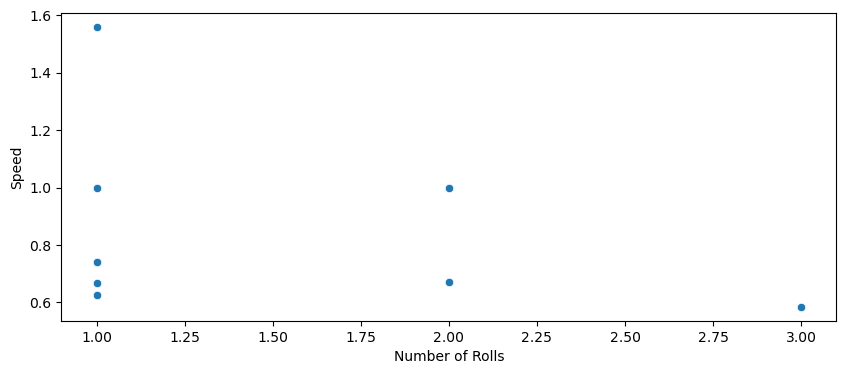

In [48]:
plt.figure(figsize=(10,4))
sns.scatterplot(data=avg_speed_driver, x='Rolls', y='Speed')
plt.xlabel('Number of Rolls')
plt.ylabel('Speed')
plt.show()

**Colclusion**: As we can see that the speed decreases as the number of rolls increases.

## Question 6: What is the successful delivery percentage of each driver?

#### Formula to calculate successful delivery percentage: Total successful orders/Total orders taken

In [50]:
succ_delivery_percentage = pd.read_sql_query('''select d.driver_id, (d.succ_deliveries/d.total_orders)*100 as successful_delivery_per from
(select a.driver_id, count(a.driver_id) as total_orders, sum(a.new_cancellation) as succ_deliveries from
(select driver_id, case when lower(cancellation) like '%cancel%' then 0 else 1 end as new_cancellation from driver_order) a
group by a.driver_id) d;''', conn)

succ_delivery_percentage

,driver_id,successful_delivery_per
0,1,100.0
1,2,75.0
2,3,50.0
